In [1]:
import numpy as np
import pickle as pkl
import h5py
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import matplotlib.patches as patches
import os
import sys
sys.path.append('/home/sofiagil/tfm/LM_V1_Billeh_model_sofia/Model_utils/')
import other_billeh_utils
import sklearn
import skimage
from skimage.measure import label, regionprops

In [2]:
# define some parameters
n_trials = 50
n_cols = 11 #11
n_rows = 13 #13
n_neurons_v1 = 90000
n_neurons_lm = 30000
# Define the time bins 250 ms stim len
time_bins = np.array([[100, 350], [450, 700], [800, 1050], [1150, 1400]])
n_timesteps = (time_bins[0,1] - time_bins[0,0]) + (time_bins[1,1] - time_bins[1,0]) + (time_bins[2,1] - time_bins[2,0]) + (time_bins[3,1] - time_bins[3,0])
print("time-steps of stimulus", n_timesteps)

time-steps of stimulus 1000


# Load data

In [3]:
v1_sums = np.zeros((n_rows, n_cols, n_neurons_v1)) # sum of all spikes per neuron and position
lm_all = np.zeros((n_rows, n_cols, n_neurons_lm)) # sum of all spikes per neuron and position

for col in tqdm(range(n_cols)):
    for row in range(n_rows):
        data_file = 'Data_connected_all/simulation_data_row_'+str(row)+'_col_'+str(col)+'_r10.hdf5'

        # Open the file in read mode
        file = h5py.File(data_file, 'r')

        # Access the 'Data' group
        data_group = file['Data']

        data = {}

        # Loop over the subgroups ('v1', 'lm', 'LGN')
        for subgroup_name in data_group.keys():
            # Access the subgroup
            subgroup = data_group[subgroup_name]
            
            # Access the 'z' dataset in the subgroup
            name = str(row)+'_'+str(col)
            dataset = subgroup[name] 
            
            # Convert the dataset to a numpy array and store it in the dictionary
            data[subgroup_name] = np.array(dataset)

        # Close the file
        file.close()

        v1 = data['v1']
        lm = data['lm']
        LGN = data['LGN']

        for time_bin in time_bins:
            v1_sums[row, col, :] += np.sum(v1[:, time_bin[0]:time_bin[1]], axis=(0,1))
            lm_all[row, col, :] += np.sum(lm[:, time_bin[0]:time_bin[1]], axis=(0,1))

# save the data
with open('Data_connected_all/v1_sums.pkl', 'wb') as f:
    pkl.dump(v1_sums, f)

with open('Data_connected_all/lm_sums.pkl', 'wb') as f:
    pkl.dump(lm_all, f)

print('Data saved')

time-steps of stimulus 1000


100%|██████████| 11/11 [1:02:11<00:00, 339.22s/it]


Data saved


# RF individual neuron

In [3]:
# select a neuron
neuron_id = 1 #2342

# define some parameters
n_trials = 50
n_cols = 11 #11
n_rows = 13 #13
n_neurons_v1 = 90000
n_neurons_lm = 30000

# Define the time bins 250 ms stim len
time_bins = np.array([[100, 350], [450, 700], [800, 1050], [1150, 1400]])
n_timesteps = (time_bins[0,1] - time_bins[0,0]) + (time_bins[1,1] - time_bins[1,0]) + (time_bins[2,1] - time_bins[2,0]) + (time_bins[3,1] - time_bins[3,0])

# load the data
with open('Data_connected_all/v1_sums.pkl', 'rb') as f:
    v1_sums = pkl.load(f)

with open('Data_connected_all/lm_sums.pkl', 'rb') as f:
    lm_all = pkl.load(f)

# normalize v1 with the number of trials and time bins to get an average firing rate per neuron, multiply by 1000 to get Hz
v1_sums = v1_sums / (n_trials * n_timesteps) * 1000
lm_all = lm_all / (n_trials * n_timesteps) * 1000

# get neuron's position
cache_path = '/home/sofiagil/tfm/LM_V1_Billeh_model_sofia/Model_utils/.cache/lm_v1_network_v1_90000_lm_30000.pkl'
with open(cache_path, 'rb') as f:
    networks, lgn_inputs, bkg_inputs = pkl.load(f)

# in networks['v1'] 'x' and 'z' are the 2 radial coordinates, and y is the depth in the column which I don't need
v1_positions_x = np.array(networks['v1']['x'])
v1_positions_z = np.array(networks['v1']['z'])

# get the position of the neuron
neuron_pos = v1_positions_x[neuron_id], v1_positions_z[neuron_id]

neuron_pos = ((neuron_pos[0]/1000 * 70/10)+6.5, (neuron_pos[1]/1000 * 40/10)+5.5) # neuron projection to visual space

print('Neuron position:', neuron_pos)

# obtain an array with all neurons positions
neurons_positions = np.zeros((n_neurons_v1, 2))
for id in range(n_neurons_v1):
    neuron_pos = v1_positions_x[id], v1_positions_z[id]
    neuron_pos = ((neuron_pos[0]/1000 * 70/10)+6.5, (neuron_pos[1]/1000 * 40/10)+5.5) # neuron projection to visual space
    neurons_positions[id] = neuron_pos

# Create the neuron types mask
# obtain the neuron type of each neuron 
new_pop_names = other_billeh_utils.pop_names(networks['v1'], n_selected_neurons=90000, data_dir='/home/sofiagil/tfm/LM_V1_Billeh_model_sofia/GLIF_network')
cell_types_v1 = [other_billeh_utils.pop_name_to_cell_type(pop_name) for pop_name in new_pop_names]

# get the neuron type of the selected neuron
neuron_type = cell_types_v1[neuron_id]

print('Neuron type:', neuron_type)

Neuron position: (6.1796849250793455, 7.335455078125)
Neuron type: L5 Exc


Expected value: 2.62
std: 0.11620702882712727
mad: 0.08000000000000007
Minimum value: 2.34
Positions above std: (array([3, 4]), array([4, 5]))
Length above std: 2
Non-inverse RF


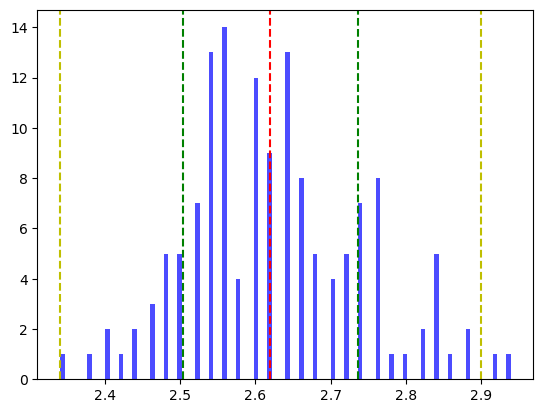

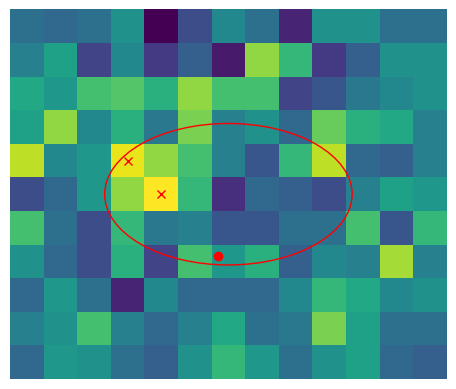

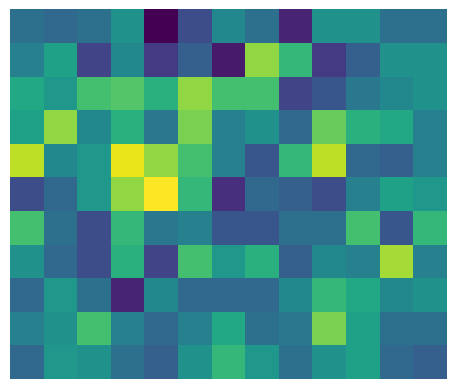

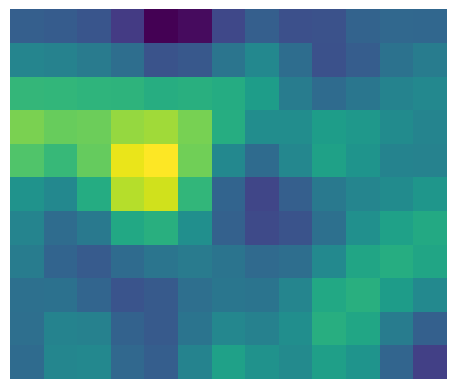

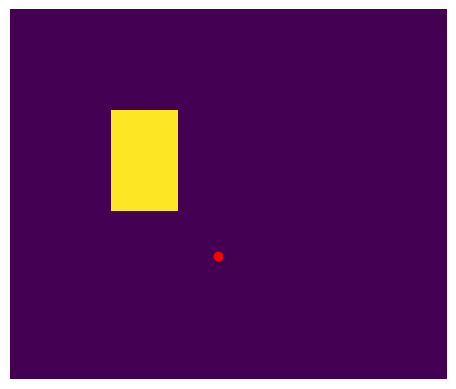

Center of mass: (4.0, 4.5)

Area: 6
Area threshold: 2.7205409447953257


In [5]:
# select the given neuron
v1_neuron = np.copy(lm_all[:,:,neuron_id]) # 1

# set 0.0 values to percentile median
expected_value = np.median(v1_neuron)
v1_neuron[np.round(v1_neuron) == 0.0] = expected_value

expected_value = np.median(v1_neuron)
std = np.std(v1_neuron)
mad = np.median(np.abs(v1_neuron - expected_value))
print("Expected value:", expected_value)
print("std:", std)
print("mad:", mad)

# plot histogram of the neuron
plt.figure()
plt.hist(v1_neuron.flatten(), bins=100, color='b', alpha=0.7)
print("Minimum value:", np.min(v1_neuron))
# plot mean and std
plt.axvline(expected_value, color='r', linestyle='--')
plt.axvline(expected_value + std, color='g', linestyle='--')
plt.axvline(expected_value - std, color='g', linestyle='--')
plt.axvline(expected_value + mad*3.5, color='y', linestyle='--')
plt.axvline(expected_value - mad*3.5, color='y', linestyle='--')

# obtain list of positions above and below the std
above_std = v1_neuron[v1_neuron > expected_value + mad*3.5]
below_std = v1_neuron[v1_neuron < expected_value - mad*3.5]

# create two new heatmaps with 1 in the given positions and 0 in the rest of them
above_std_map_binary = np.zeros(v1_neuron.shape)
below_std_map_binary = np.zeros(v1_neuron.shape)
# merge
above_below_std = np.concatenate((above_std, below_std))

if len(above_std) > 0:
    for i in range(len(above_std)):
        idx = np.where(v1_neuron == above_std[i])
        above_std_map_binary[idx] = 1

    # labelling connected components
    above_std_map = skimage.measure.label(above_std_map_binary)
    # get the largest connected component of each map
    above_std_map = (above_std_map == np.argmax(np.bincount(above_std_map.flat)[1:]) + 1)
    # get the list of positions
    above_std_positions_largest = np.where(above_std_map == 1)
    # print the positions
    print('Positions above std:', above_std_positions_largest)
    # compare lengths of above and below std
    print('Length above std:', len(above_std_positions_largest[0]))
else:
    above_std_positions_largest = [[]]

if len(below_std) > 0:
    for i in range(len(below_std)):
        idx = np.where(v1_neuron == below_std[i])
        below_std_map_binary[idx] = 1

    below_std_map = skimage.measure.label(below_std_map_binary)
    below_std_map = (below_std_map == np.argmax(np.bincount(below_std_map.flat)[1:]) + 1)
    below_std_positions_largest = np.where(below_std_map == 1)
    print('Positions below std:', below_std_positions_largest)
    print('Length below std:', len(below_std_positions_largest[0]))
else:
    below_std_positions_largest = [[]]

if len(below_std_positions_largest[0]) > len(above_std_positions_largest[0]):
    inverse = True
    print('Inverse RF')
else:
    inverse = False
    print('Non-inverse RF')

# plot without gaussian filter
plt.figure()
ax = sns.heatmap(v1_neuron.T, cmap='viridis', square=True, cbar = False)

# add a cross at positions in above_below_std list
for i in range(len(above_below_std)):
    idx = np.where(v1_neuron == above_below_std[i])
    plt.plot(idx[0]+0.5, idx[1]+0.5, 'rx')

# remove axis and color bar
plt.axis('off')

# Get the current tick locations and labels
xticks, xlabels = plt.xticks()
yticks, ylabels = plt.yticks()

# Convert the labels to integers, add 1, and convert back to string
xlabels = [str(int(label.get_text()) + 1) for label in xlabels]
ylabels = [str(int(label.get_text()) + 1) for label in ylabels]

# Set the new labels
ax.set_xticklabels(xlabels);
ax.set_yticklabels(ylabels);

# obtain the v1 projection ellipse
x_axis = (max(v1_positions_x)/1000 * 70/10) - (min(v1_positions_x)/1000 * 70/10)
y_axis = (max(v1_positions_z)/1000 * 40/10) - (min(v1_positions_z)/1000 * 40/10)

# center is at 6,5
center = (6.5,5.5)

# create the ellipse
ellipse = patches.Ellipse(center, width=x_axis, height=y_axis, fill=False, edgecolor='r')
ax.add_patch(ellipse)

# plot the neuron position	
neuron_pos = neurons_positions[neuron_id]
plt.plot(neuron_pos[0], neuron_pos[1], 'ro')

if inverse:
    # obtain lists of the positions of all the connected components
    connected_components = label(below_std_map_binary)

    # Identify the largest connected component
    largest_cc_label = max(regionprops(connected_components), key=lambda r: r.area).label

    # Create a mask for the largest connected component and set it to 0
    below_std_map_binary[connected_components == largest_cc_label] = 0

    mask = (below_std_map_binary == 1)
    outlier_values = v1_neuron[mask]

    threshold = np.max(outlier_values)

    # set values below or equal to threshold to the median
    v1_neuron[v1_neuron <= threshold] = expected_value

    # plot the RF
    plt.figure()
    ax = sns.heatmap(v1_neuron.T, cmap='viridis', cbar_kws={'label': 'Average firing rate (Hz)'}, square = True, cbar = False)
    plt.axis('off')

    smooth_rf = scipy.ndimage.gaussian_filter(v1_neuron, sigma=1)
    # plot the smoothed RF
    # plt.figure()
    # ax = sns.heatmap(smooth_rf.T, cmap='viridis', cbar_kws={'label': 'Average firing rate (Hz)'}, square = True, cbar = False)
    # plt.axis('off')

    v1_neuron_smooth = np.max(smooth_rf) - smooth_rf
    print("inverse neuron")

    # plot the smoothed RF
    plt.figure()
    ax = sns.heatmap(v1_neuron_smooth.T, cmap='viridis', cbar_kws={'label': 'Average firing rate (Hz)'}, square = True, cbar = False)
    plt.axis('off')
else:
    connected_components = label(below_std_map_binary)

    mask = (below_std_map_binary == 1)
    outlier_values = v1_neuron[mask]

    if len(outlier_values>0):
        threshold = np.max(outlier_values)
    else:
        threshold = 0

    # set values below or equal to threshold to the median
    v1_neuron[v1_neuron <= threshold] = expected_value

    # plot the RF
    plt.figure()
    ax = sns.heatmap(v1_neuron.T, cmap='viridis', cbar_kws={'label': 'Average firing rate (Hz)'}, square = True, cbar = False)
    plt.axis('off')

    v1_neuron_smooth = scipy.ndimage.gaussian_filter(v1_neuron, sigma=1)

    # plot the smoothed RF
    plt.figure()
    ax = sns.heatmap(v1_neuron_smooth.T, cmap='viridis', cbar_kws={'label': 'Average firing rate (Hz)'}, square = True, cbar = False)
    plt.axis('off')

# now apply the threshold at max(RF) – std(RF)
threshold = np.max(v1_neuron_smooth) - np.std(v1_neuron_smooth)
v1_neuron_thresholded = np.zeros(v1_neuron_smooth.shape)
v1_neuron_thresholded[v1_neuron_smooth > threshold] = 1

# plot the thresholded receptive field
plt.figure()
ax = sns.heatmap(v1_neuron_thresholded.T, cmap='viridis', cbar_kws={'label': 'Average firing rate (Hz)'}, square = True, cbar = False)

# Get the current tick locations and labels
xticks, xlabels = plt.xticks()
yticks, ylabels = plt.yticks()

plt.axis('off')

# plot the neuron position	
plt.plot(neuron_pos[0], neuron_pos[1], 'ro')

plt.show()

# Label the connected components
labeled_components = label(v1_neuron_thresholded)

# Get properties of all labeled regions
regions = regionprops(labeled_components)

# Find the largest connected component
largest_cc = max(regions, key=lambda r: r.area)

# Get the center of mass of the largest connected component
center_of_mass_v1 = largest_cc.centroid

# add 0.5 to each component
center_of_mass_v1 = (center_of_mass_v1[0] + 0.5, center_of_mass_v1[1] + 0.5)

print('Center of mass:', center_of_mass_v1)

# compute the area of the thresholded RF
# select the largest connected component
neuron_thresholded = skimage.measure.label(v1_neuron_thresholded)
v1_neuron_thresholded = (neuron_thresholded == np.argmax(np.bincount(neuron_thresholded.flat)[1:]) + 1)

area = np.sum(v1_neuron_thresholded)
print('\nArea:', area)
print('Area threshold:', threshold)

# Compute RF

In [6]:
# get neuron's position
cache_path = '/home/sofiagil/tfm/LM_V1_Billeh_model_sofia/Model_utils/.cache/lm_v1_network_v1_90000_lm_30000.pkl'
with open(cache_path, 'rb') as f:
    networks, lgn_inputs, bkg_inputs = pkl.load(f)

# in networks['v1'] 'x' and 'z' are the 2 radial coordinates, and y is the depth in the column which I don't need
v1_positions_x = np.array(networks['v1']['x'])
v1_positions_z = np.array(networks['v1']['z'])

# obtain an array with all neurons positions
neurons_positions = np.zeros((n_neurons_v1, 2))
for id in range(n_neurons_v1):
    neuron_pos = v1_positions_x[id], v1_positions_z[id]
    neuron_pos = ((neuron_pos[0]/1000 * 70/10)+6.5, (neuron_pos[1]/1000 * 40/10)+5.5) # neuron projection to visual space
    neurons_positions[id] = neuron_pos

In [7]:
# define some parameters
n_trials = 50
n_cols = 11 #11
n_rows = 13 #13
n_neurons_v1 = 90000
n_neurons_lm = 30000

# Define the time bins 250 ms stim len
time_bins = np.array([[100, 350], [450, 700], [800, 1050], [1150, 1400]])
n_timesteps = (time_bins[0,1] - time_bins[0,0]) + (time_bins[1,1] - time_bins[1,0]) + (time_bins[2,1] - time_bins[2,0]) + (time_bins[3,1] - time_bins[3,0])

# load the data
with open('Data_connected_all/v1_sums.pkl', 'rb') as f:
    v1_sums = pkl.load(f)

with open('Data_connected_all/lm_sums.pkl', 'rb') as f:
    lm_all = pkl.load(f)

# normalize v1 with the number of trials and time bins to get an average firing rate per neuron, multiply by 1000 to get Hz
v1_sums = v1_sums / (n_trials * n_timesteps) * 1000
lm_all = lm_all / (n_trials * n_timesteps) * 1000

In [8]:
# V1
rf_areas_v1 = np.zeros((n_neurons_v1))
inverse_indices_v1 = []
center_of_mass_v1 = np.zeros((n_neurons_v1, 2))

for neuron in tqdm(range(n_neurons_v1)):
    # select the given neuron
    v1_neuron = np.copy(v1_sums[:,:,neuron])
    expected_value = np.median(v1_neuron)
    # set 0.0 values to percentile median
    v1_neuron[np.round(v1_neuron) == 0.0] = expected_value
    mad = np.median(np.abs(v1_neuron - expected_value))

    # obtain list of positions above and below the std
    above_std = v1_neuron[v1_neuron > expected_value + mad*3.5]
    below_std = v1_neuron[v1_neuron < expected_value - mad*3.5]
    
    above_std_map_binary = np.zeros(v1_neuron.shape)
    below_std_map_binary = np.zeros(v1_neuron.shape)
    # merge
    above_below_std = np.concatenate((above_std, below_std))

    if len(above_std) > 0:
        for i in range(len(above_std)):
            idx = np.where(v1_neuron == above_std[i])
            above_std_map_binary[idx] = 1

        # labelling connected components
        above_std_map = skimage.measure.label(above_std_map_binary)
        # get the largest connected component of each map
        above_std_map = (above_std_map == np.argmax(np.bincount(above_std_map.flat)[1:]) + 1)
        # get the list of positions
        above_std_positions_largest = np.where(above_std_map == 1)

    else:
        above_std_positions_largest = [[]]  

    if len(below_std) > 0:
        for i in range(len(below_std)):
            idx = np.where(v1_neuron == below_std[i])
            below_std_map_binary[idx] = 1

        below_std_map = skimage.measure.label(below_std_map_binary)
        below_std_map = (below_std_map == np.argmax(np.bincount(below_std_map.flat)[1:]) + 1)
        below_std_positions_largest = np.where(below_std_map == 1)

    else:
        below_std_positions_largest = [[]]

    if len(below_std_positions_largest[0]) > len(above_std_positions_largest[0]):
        inverse = True
    else:
        inverse = False

    if inverse:
        inverse_indices_v1.append(neuron)
        # obtain lists of the positions of all the connected components
        connected_components = label(below_std_map_binary)

        # Identify the largest connected component
        largest_cc_label = max(regionprops(connected_components), key=lambda r: r.area).label

        # Create a mask for the largest connected component and set it to 0
        below_std_map_binary[connected_components == largest_cc_label] = 0

        mask = (below_std_map_binary == 1)
        outlier_values = v1_neuron[mask]

        if len(outlier_values) > 0:
            threshold = np.max(outlier_values)
        else:
            threshold = 0

        # set values below or equal to threshold to the median
        v1_neuron[v1_neuron <= threshold] = expected_value

        smooth_rf = scipy.ndimage.gaussian_filter(v1_neuron, sigma=1)

        v1_neuron_smooth = np.max(smooth_rf) - smooth_rf

    else:
        connected_components = label(below_std_map_binary)

        mask = (below_std_map_binary == 1)
        outlier_values = v1_neuron[mask]

        if len(outlier_values)>0:
            threshold = np.max(outlier_values)
        else:
            threshold = 0

        # set values below or equal to threshold to the median
        v1_neuron[v1_neuron <= threshold] = expected_value

        v1_neuron_smooth = scipy.ndimage.gaussian_filter(v1_neuron, sigma=1)

    # now apply the threshold at max(RF) – std(RF)
    threshold = np.max(v1_neuron_smooth) - np.std(v1_neuron_smooth)
    v1_neuron_thresholded = np.zeros(v1_neuron_smooth.shape)
    v1_neuron_thresholded[v1_neuron_smooth > threshold] = 1

    # compute the area of the thresholded RF
    # select the largest connected component
    neuron_thresholded = skimage.measure.label(v1_neuron_thresholded)
    try:
        v1_neuron_thresholded = (neuron_thresholded == np.argmax(np.bincount(neuron_thresholded.flat)[1:]) + 1)
    except:
        v1_neuron_thresholded = np.zeros(v1_neuron_smooth.shape)

    # comptue the center of mass
    center_of_mass_v1[neuron] = np.array([np.mean(np.where(v1_neuron_thresholded)[0]), np.mean(np.where(v1_neuron_thresholded)[1])])
    # add 0.5 to each coordinate to get the center of the pixel
    center_of_mass_v1[neuron] = (center_of_mass_v1[neuron][0]+0.5, center_of_mass_v1[neuron][1]+0.5)
    rf_areas_v1[neuron] = np.sum(v1_neuron_thresholded)*100

    if rf_areas_v1[neuron] > 2500 or rf_areas_v1[neuron] <= 0:
        # set to nan
        rf_areas_v1[neuron] = np.nan

# LM
rf_areas_lm = np.zeros((n_neurons_lm))
inverse_indices_lm = []
center_of_mass_lm = np.zeros((n_neurons_lm, 2))

for neuron in tqdm(range(n_neurons_lm)):
    # select the given neuron
    lm_neuron = np.copy(lm_all[:,:,neuron])
    expected_value = np.median(lm_neuron)
    # set 0.0 values to percentile median
    lm_neuron[np.round(lm_neuron) == 0.0] = expected_value
    mad = np.median(np.abs(lm_neuron - expected_value))

    # obtain list of positions above and below the std
    above_std = lm_neuron[lm_neuron > expected_value + mad*3.5]
    below_std = lm_neuron[lm_neuron < expected_value - mad*3.5]
    
    above_std_map_binary = np.zeros(lm_neuron.shape)
    below_std_map_binary = np.zeros(lm_neuron.shape)
    # merge
    above_below_std = np.concatenate((above_std, below_std))

    if len(above_std) > 0:
        for i in range(len(above_std)):
            idx = np.where(lm_neuron == above_std[i])
            above_std_map_binary[idx] = 1

        # labelling connected components
        above_std_map = skimage.measure.label(above_std_map_binary)
        # get the largest connected component of each map
        above_std_map = (above_std_map == np.argmax(np.bincount(above_std_map.flat)[1:]) + 1)
        # get the list of positions
        above_std_positions_largest = np.where(above_std_map == 1)

    else:
        above_std_positions_largest = [[]]  

    if len(below_std) > 0:
        for i in range(len(below_std)):
            idx = np.where(lm_neuron == below_std[i])
            below_std_map_binary[idx] = 1

        below_std_map = skimage.measure.label(below_std_map_binary)
        below_std_map = (below_std_map == np.argmax(np.bincount(below_std_map.flat)[1:]) + 1)
        below_std_positions_largest = np.where(below_std_map == 1)

    else:
        below_std_positions_largest = [[]]

    if len(below_std_positions_largest[0]) > len(above_std_positions_largest[0]):
        inverse = True
    else:
        inverse = False

    if inverse:
        inverse_indices_lm.append(neuron)
        # obtain lists of the positions of all the connected components
        connected_components = label(below_std_map_binary)

        # Identify the largest connected component
        largest_cc_label = max(regionprops(connected_components), key=lambda r: r.area).label

        # Create a mask for the largest connected component and set it to 0
        below_std_map_binary[connected_components == largest_cc_label] = 0

        mask = (below_std_map_binary == 1)
        outlier_values = lm_neuron[mask]

        if len(outlier_values) > 0:
            threshold = np.max(outlier_values)
        else:
            threshold = 0

        # set values below or equal to threshold to the median
        lm_neuron[lm_neuron <= threshold] = expected_value

        smooth_rf = scipy.ndimage.gaussian_filter(lm_neuron, sigma=1)

        lm_neuron_smooth = np.max(smooth_rf) - smooth_rf

    else:
        connected_components = label(below_std_map_binary)

        mask = (below_std_map_binary == 1)
        outlier_values = lm_neuron[mask]

        if len(outlier_values)>0:
            threshold = np.max(outlier_values)
        else:
            threshold = 0

        # set values below or equal to threshold to the median
        lm_neuron[lm_neuron <= threshold] = expected_value

        lm_neuron_smooth = scipy.ndimage.gaussian_filter(lm_neuron, sigma=1)

    # now apply the threshold at max(RF) – std(RF)
    threshold = np.max(lm_neuron_smooth) - np.std(lm_neuron_smooth)
    lm_neuron_thresholded = np.zeros(lm_neuron_smooth.shape)
    lm_neuron_thresholded[lm_neuron_smooth > threshold] = 1

    # compute the area of the thresholded RF
    # select the largest connected component
    neuron_thresholded = skimage.measure.label(lm_neuron_thresholded)
    try:
        lm_neuron_thresholded = (neuron_thresholded == np.argmax(np.bincount(neuron_thresholded.flat)[1:]) + 1)
    except:
        lm_neuron_thresholded = np.zeros(lm_neuron_smooth.shape)

    # comptue the center of mass
    center_of_mass_lm[neuron] = np.array([np.mean(np.where(lm_neuron_thresholded)[0]), np.mean(np.where(lm_neuron_thresholded)[1])])
    # add 0.5 to each coordinate to get the center of the pixel
    center_of_mass_lm[neuron] = (center_of_mass_lm[neuron][0]+0.5, center_of_mass_lm[neuron][1]+0.5)
    rf_areas_lm[neuron] = np.sum(lm_neuron_thresholded)*100

    if rf_areas_lm[neuron] > 2500 or rf_areas_lm[neuron] <= 0:
        # set to nan
        rf_areas_lm[neuron] = np.nan

# save the data
with open('Data_connected_all/rf_areas_v1.pkl', 'wb') as f:
    pkl.dump(rf_areas_v1, f)

with open('Data_connected_all/rf_areas_lm.pkl', 'wb') as f:
    pkl.dump(rf_areas_lm, f)

  0%|          | 228/90000 [00:00<01:23, 1071.47it/s]

 12%|█▏        | 10990/90000 [00:04<00:30, 2583.40it/s]/home/sofiagil/.conda/envs/tfm_jupyter/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sofiagil/.conda/envs/tfm_jupyter/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 30000/30000 [00:10<00:00, 2759.19it/s]


In [9]:
cache_path = '/home/sofiagil/tfm/LM_V1_Billeh_model_sofia/Model_utils/.cache/lm_v1_network_v1_90000_lm_30000.pkl'
with open(cache_path, 'rb') as f:
    networks, lgn_inputs, bkg_inputs = pkl.load(f)

new_pop_names_v1 = other_billeh_utils.pop_names(networks['v1'], n_selected_neurons=90000, data_dir='/home/sofiagil/tfm/LM_V1_Billeh_model_sofia/GLIF_network')
new_pop_names_lm = other_billeh_utils.pop_names(networks['lm'], n_selected_neurons=30000, data_dir='/home/sofiagil/tfm/LM_V1_Billeh_model_sofia/GLIF_network')

In [10]:
# create a dataframe for v1 and lm
import pandas as pd
v1_df = pd.DataFrame()
lm_df = pd.DataFrame()

# 1st column is the neuron id
v1_df['neuron_id'] = np.arange(n_neurons_v1)
lm_df['neuron_id'] = np.arange(n_neurons_lm)

# the next column is the neuron type
v1_df['neuron_type'] = new_pop_names_v1
lm_df['neuron_type'] = new_pop_names_lm

# 2nd column is the area of the RF
v1_df['RF_area'] = rf_areas_v1
lm_df['RF_area'] = rf_areas_lm	

# 3rd column ist the center of mass
v1_df['RF_center'] = list(center_of_mass_v1)
lm_df['RF_center'] = list(center_of_mass_lm)

# save the dataframes
v1_df.to_csv('v1_df_all.csv')
lm_df.to_csv('lm_df_all.csv')